In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
 

In [ ]:
class Generator(nn.Module):
  def __init__(self,z_dim = 64, img_dim =(1,28,28)):
    super(Generator,self).__init__()

    self.img_dim = img_dim

    self.net = nn.Sequential(
        nn.Linear(z_dim, 256),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Linear(256,512),
        nn.LeakyReLU(0.2,inplace=True),
        nn.BatchNorm1d(512,0.8),
        nn.Linear(512,1024),
        nn.BatchNorm1d(1024,0.8),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Linear(1024,img_dim[1]*img_dim[2]),
        nn.Tanh()
    )

  def forward(self,z):
    img = self.net(z)
    img_dim = self.img_dim
    img = img.view(-1,img_dim[0],img_dim[1],img_dim[2])
    return img

In [ ]:
z = torch.rand((100,64))
gen = Generator()
out = gen(z)
print(out.shape)


torch.Size([100, 1, 28, 28])


In [ ]:
class Discriminator(nn.Module):
  def __init__(self,img_shape=(1,28,28)):
    super(Discriminator,self).__init__()

    self.net = nn.Sequential(
        nn.Linear(img_shape[1]*img_shape[2],512),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(512,256),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(256,1),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = torch.flatten(x,1)
    out = self.net(x)
    return out

In [ ]:
x = torch.rand((100,1,28,28))
disc = Discriminator()
out = disc(x)
print(out.shape) 


torch.Size([100, 1])


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")                                                                                                               

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision


transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])


optimizer_gen = torch.optim.Adam(gen.parameters(),lr=3e-4)
optimizer_disc = torch.optim.Adam(disc.parameters(),lr=3e-4)
criterion = nn.BCELoss()



dataset = datasets.MNIST(root='./data', download=True,
                               transform= transform)


image_dim = 28 * 28 *1
batch_size = 32
num_epochs = 50
z_dim = 64

loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

gen.to(device)
disc.to(device)



Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!





/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Discriminator(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:


fixed_noise = torch.randn((batch_size, z_dim)).to(device)

step = 0
for epoch in range(num_epochs):
  for batch_idx, (real,_) in enumerate(loader):

    real = real.view(-1, 784).to(device)
    batch_size = real.shape[0]

    ##Train Discriminator: max log(D(x)) + log(1-D(G(z)))
    noise = torch.randn(batch_size,z_dim).to(device)
    fake = gen(noise)
    
    disc_real = disc(real).view(-1)
    lossD_real = criterion(disc_real, torch.ones_like(disc_real))
    disc_fake =  disc(fake).view(-1)
    lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
    lossD = (lossD_real + lossD_fake) / 2
    disc.zero_grad()
    lossD.backward(retain_graph=True)
    optimizer_disc.step()

    ### Train Generator: min log(1-D(G(z))) <-> max log(D(G(z)))
    output = disc(fake).view(-1)
    lossG = criterion(output, torch.ones_like(output))
    gen.zero_grad()
    lossG.backward()
    optimizer_gen.step()

    if batch_idx == 0:
      print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
                      Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
      )

      step += 1


Epoch [0/50] Batch 0/1875                       Loss D: 0.5789, loss G: 1.6372
Epoch [1/50] Batch 0/1875                       Loss D: 0.6048, loss G: 1.2834
Epoch [2/50] Batch 0/1875                       Loss D: 0.5134, loss G: 1.4413
Epoch [3/50] Batch 0/1875                       Loss D: 0.5668, loss G: 1.1033
Epoch [4/50] Batch 0/1875                       Loss D: 0.5103, loss G: 1.2510
Epoch [5/50] Batch 0/1875                       Loss D: 0.6418, loss G: 0.9778
Epoch [6/50] Batch 0/1875                       Loss D: 0.4629, loss G: 1.3787
Epoch [7/50] Batch 0/1875                       Loss D: 0.4791, loss G: 1.6447
Epoch [8/50] Batch 0/1875                       Loss D: 0.5443, loss G: 1.3117
Epoch [9/50] Batch 0/1875                       Loss D: 0.5040, loss G: 1.1301
Epoch [10/50] Batch 0/1875                       Loss D: 0.5395, loss G: 1.2079
Epoch [11/50] Batch 0/1875                       Loss D: 0.4956, loss G: 1.3784
Epoch [12/50] Batch 0/1875                       L

In [ ]:
with torch.no_grad():
 
  img_grid_real = torchvision.utils.make_grid(data, normalize=True)

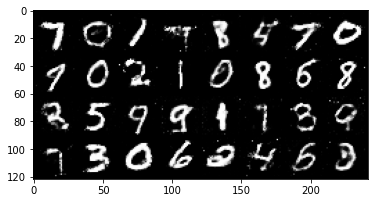

In [ ]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img =img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()



# show images
imshow(img_grid_fake)